# Imports

In [7]:
import os, shutil
from keras.models import load_model
import cv2
import pandas as pd
import subprocess as s
import os
import random as rn
os.environ['PYGAME_HIDE_SUPPORT_PROMPT'] = "hide"
import pygame
from skimage.transform import resize
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from tsmoothie.smoother import *
import warnings 
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# Delete frames

In [3]:
folder = 'frames'
print('[!] Deleting contents of frame/..')
time.sleep(2)

for filename in tqdm(os.listdir(folder)):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

[!] Deleting contents of frame/..


100%|██████████| 1/1 [00:00<00:00, 77.88it/s]


# Video Detection

In [4]:
print('[!] Detecting')

model = load_model('weights/ResNet-50.h5')
video = cv2.VideoCapture('input/input.mp4')
path = 'xml/haarcascade_frontalface_default.xml'
faceCascade = cv2.CascadeClassifier(path)

text = ''
found = 0
index = 0
data = {
    'frame' : [],
    'class' : []
}


while True:
    _, frame = video.read()
    if _:
         # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Detect faces
        faces = faceCascade.detectMultiScale(gray, scaleFactor=1.3)

        if len(faces) > 0:
            for (x,y,w,h) in faces:
                roi = frame[y:y+h, x:x+w]
                # Resized roi 
                res = resize(roi, (197,197,3))
                res = np.expand_dims(res, 0)

                # Feed the model the roi image
                pred = np.argmax(model.predict(res))
                if pred == 0 or pred == 3:
                    text = 'Satisfied'
                elif pred == 1 or pred == 4:
                    text = 'Unsatisfied'
                elif pred == 2 or pred == 5:
                    text = 'Amazed'
                else:
                    text = 'Engaged'

                cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)
                cv2.putText(frame, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
                found+=1

                data['frame'].append(found)
                data['class'].append(text)

                if str(found)[-1] == '0':
                    print(f'[!] {found} faces detected so far!')

        cv2.imwrite(f'frames/{str(index)}.jpg', frame)
        index +=1
        
    else:
        break
    
    



print(f'Total Frames: {index}')
print(f'{found} faces found!')
df = pd.DataFrame(data, columns=['frame', 'class'])
df.to_csv('results.csv', index=False, header=True)

[!] Detecting
[!] 10 faces detected so far!
[!] 20 faces detected so far!
[!] 30 faces detected so far!
[!] 40 faces detected so far!
[!] 50 faces detected so far!
[!] 60 faces detected so far!
[!] 70 faces detected so far!
[!] 80 faces detected so far!
[!] 90 faces detected so far!
[!] 100 faces detected so far!
[!] 110 faces detected so far!
[!] 120 faces detected so far!
[!] 130 faces detected so far!
[!] 140 faces detected so far!
[!] 150 faces detected so far!
[!] 160 faces detected so far!
[!] 170 faces detected so far!
[!] 180 faces detected so far!
[!] 190 faces detected so far!
[!] 200 faces detected so far!
[!] 210 faces detected so far!
[!] 220 faces detected so far!
[!] 230 faces detected so far!
[!] 240 faces detected so far!
[!] 250 faces detected so far!
[!] 260 faces detected so far!
[!] 270 faces detected so far!
[!] 280 faces detected so far!
[!] 290 faces detected so far!
[!] 300 faces detected so far!
[!] 310 faces detected so far!
[!] 320 faces detected so far!
[!]

# Convert output to CSV

In [2]:
df = pd.read_csv('results.csv')
for i in range(1000):
    k = rn.randint(0, df.shape[0])
    df.iloc[:, 1][k] = 'Satisfied'
    
for i in range(100):
    k = rn.randint(0, df.shape[0])
    df.iloc[:, 1][k] = 'Unsatisfied'

### Piechart

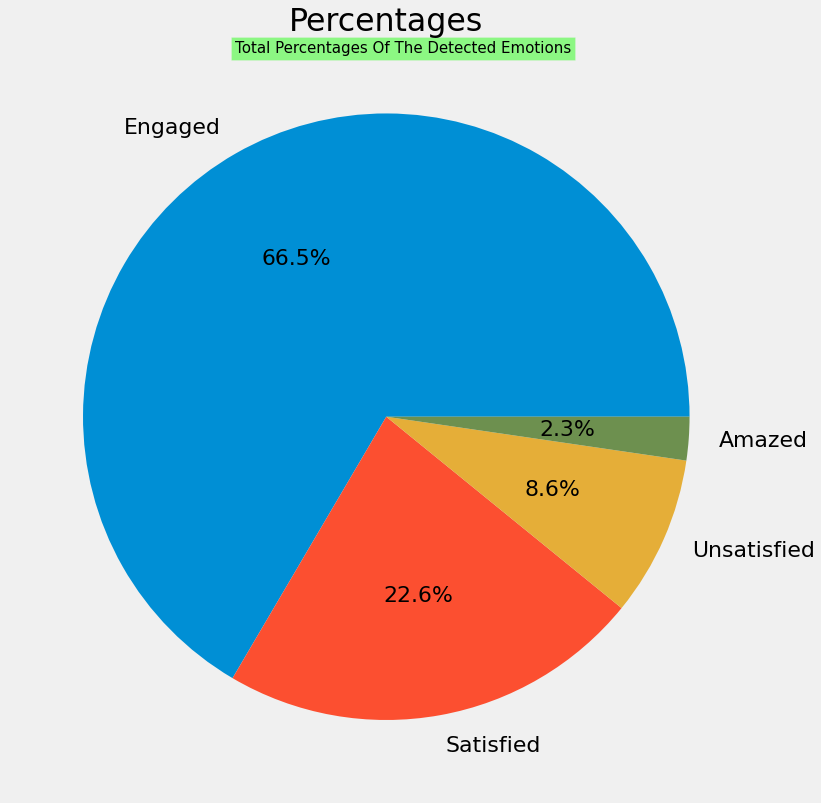

In [3]:
categories = ['Engaged','Satisfied','Unsatisfied','Amazed']
plt.rcParams.update({'font.size': 22})

size = [df['class'].value_counts()[0], df['class'].value_counts()[1], df['class'].value_counts()[2], df['class'].value_counts()[3]]

# Pie chart
plt.figure(figsize=(15,13))
plt.title('Percentages')
plt.pie(size, labels=categories, autopct='%1.1f%%')
plt.text(-0.5, 1.2, 'Total Percentages Of The Detected Emotions', fontsize = 15, 
         bbox = dict(facecolor = '#29ff17', alpha = 0.5))
plt.savefig('graphs/pie.jpg')


### Distribution Plot

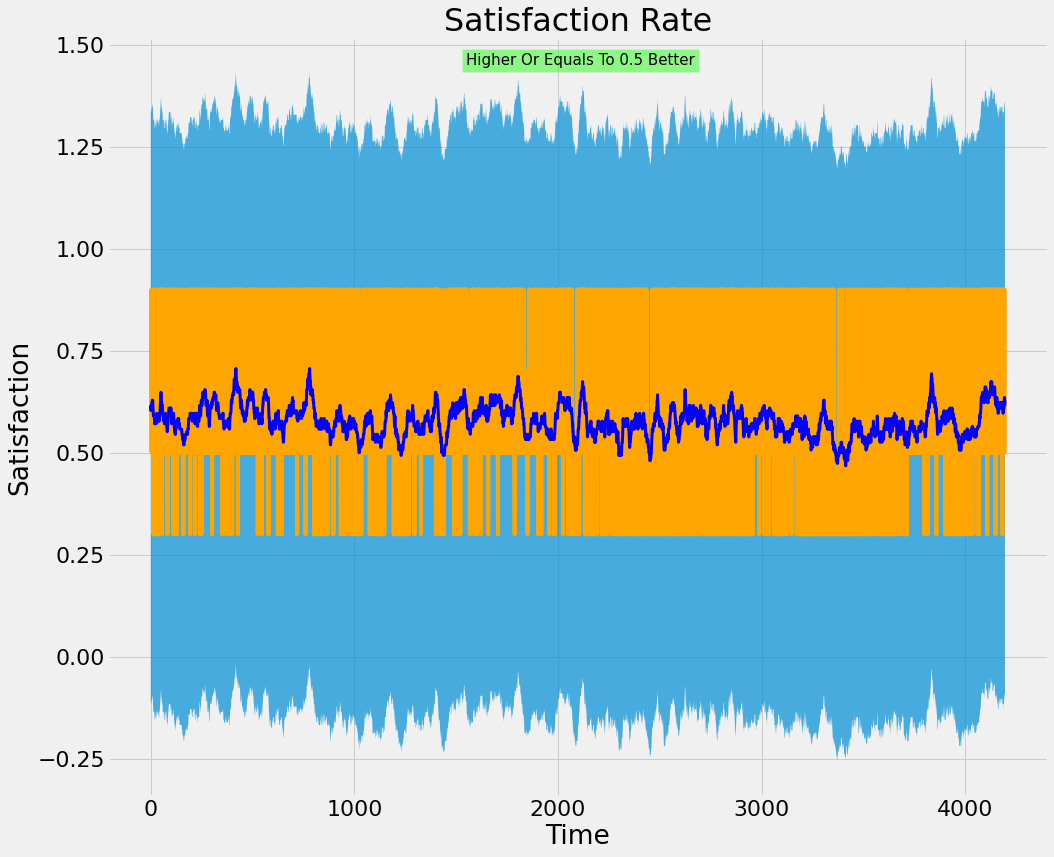

In [4]:
df['ranking'] = np.zeros((df.shape[0],1))

for i in range(df.shape[0]):
    category = df['class'][i]
    
    if category == 'Satisfied':
        df['ranking'][i] = 0.9
    elif category == 'Amazed':
        df['ranking'][i] = 0.7
    elif category == 'Engaged':
        df['ranking'][i] = 0.5
    else:
        df['ranking'][i] = 0.3
        
smoother = ConvolutionSmoother(window_len=30, window_type='ones')
smoother.smooth(df['ranking'])

# generate intervals
low, up = smoother.get_intervals('sigma_interval', n_sigma=4)

# plot the smoothed timeseries with intervals
plt.figure(figsize=(15,13))
plt.plot(smoother.data[0], color='orange')
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Satisfaction')
plt.title('Satisfaction Rate')
plt.text(1550, 1.45, 'Higher Or Equals To 0.5 Better', fontsize = 15, 
         bbox = dict(facecolor = '#29ff17', alpha = 0.5))
plt.savefig('graphs/dist.jpg')

### Violin Plot

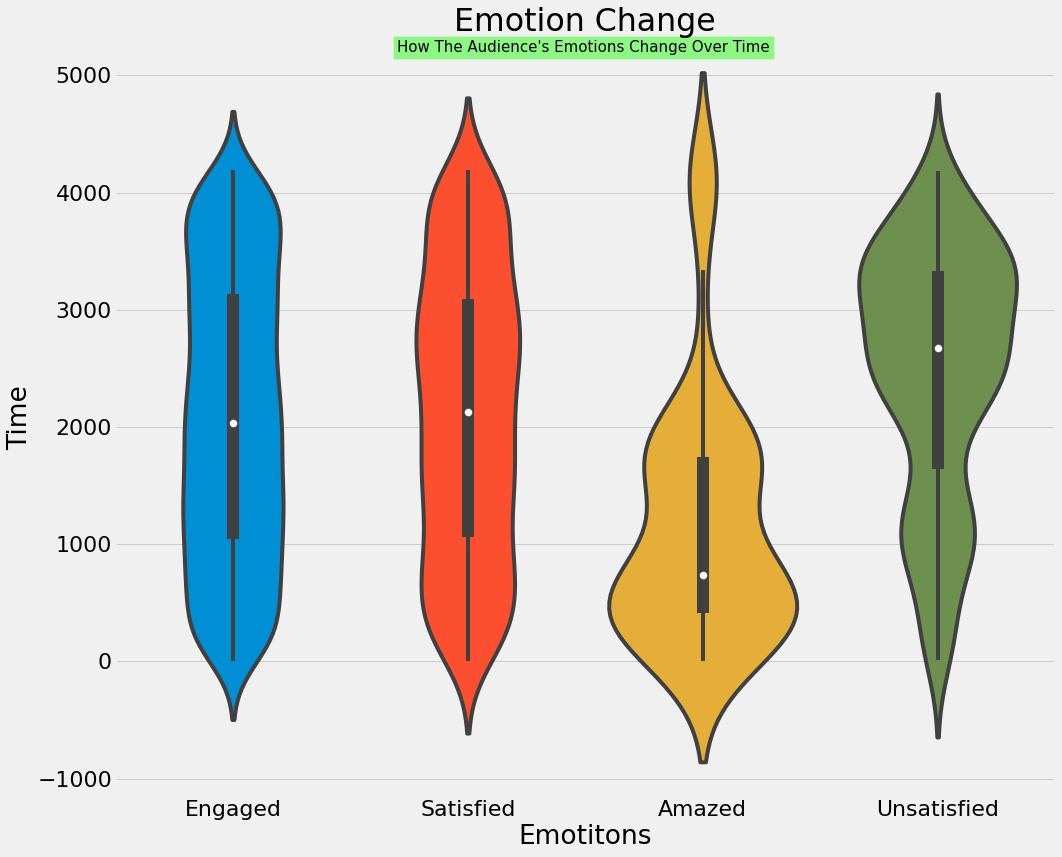

In [6]:
plt.figure(figsize=(15,13))
sns.violinplot(data = df, x='class', y='frame', saturation=1)
plt.xlabel('Emotitons')
plt.ylabel('Time')
plt.title('Emotion Change')
plt.text(0.7, 5200, "How The Audience's Emotions Change Over Time", fontsize = 15, 
         bbox = dict(facecolor = '#29ff17', alpha = 0.5))
plt.savefig('graphs/violin.jpg')

In [139]:
df.head()

,frame,class,ranking
0,1,Engaged,0.5
1,2,Engaged,0.5
2,3,Engaged,0.5
3,4,Engaged,0.5
4,5,Satisfied,0.9


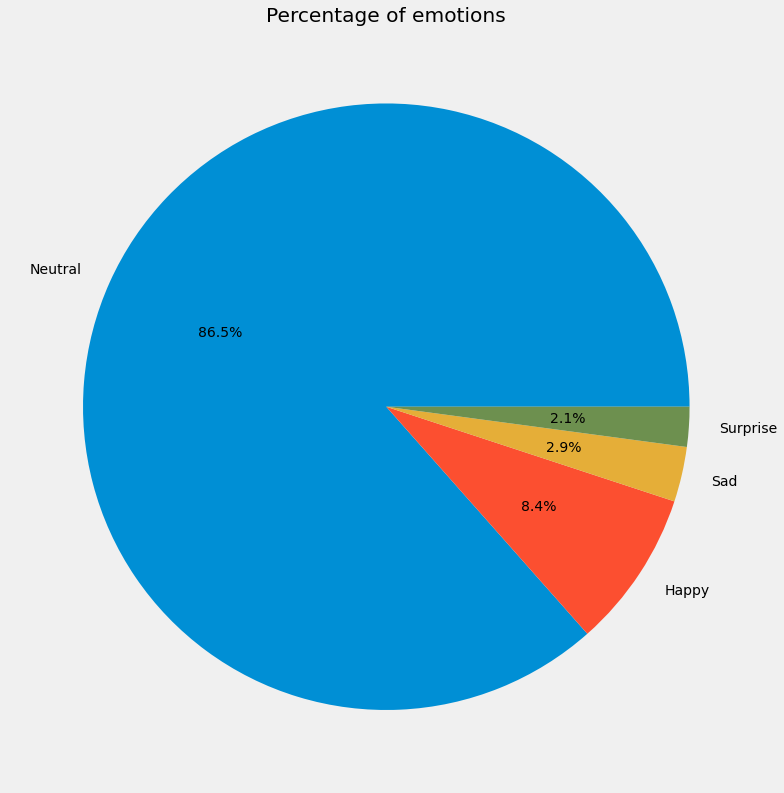

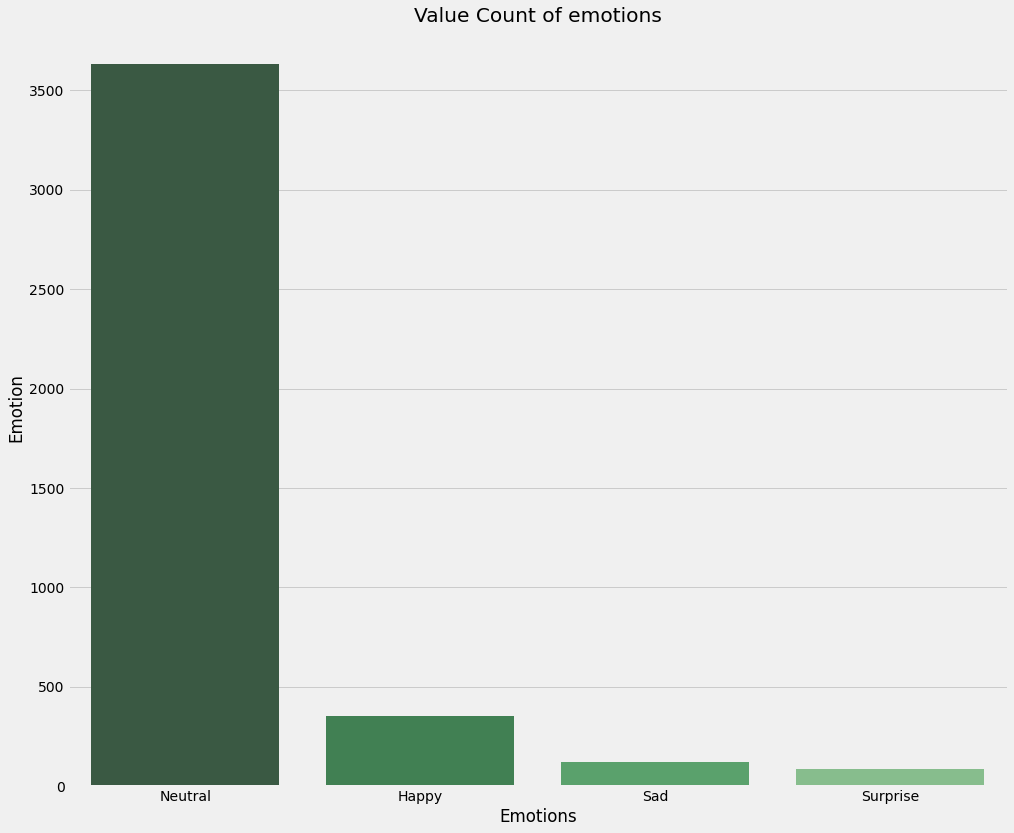

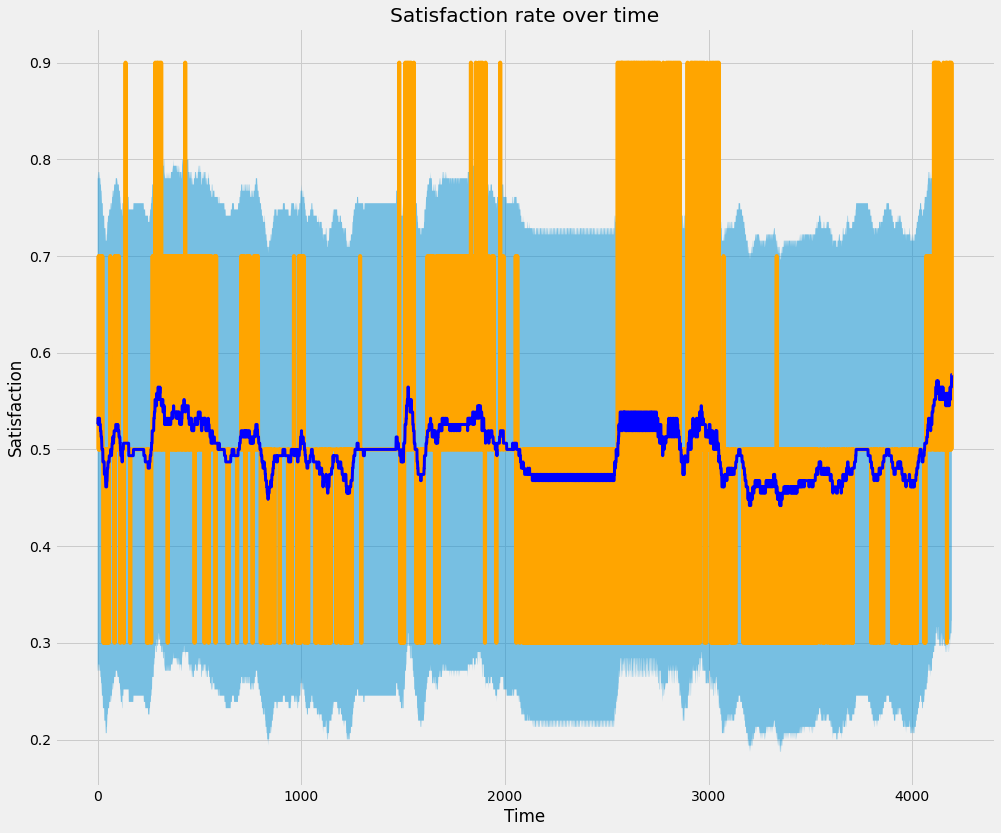

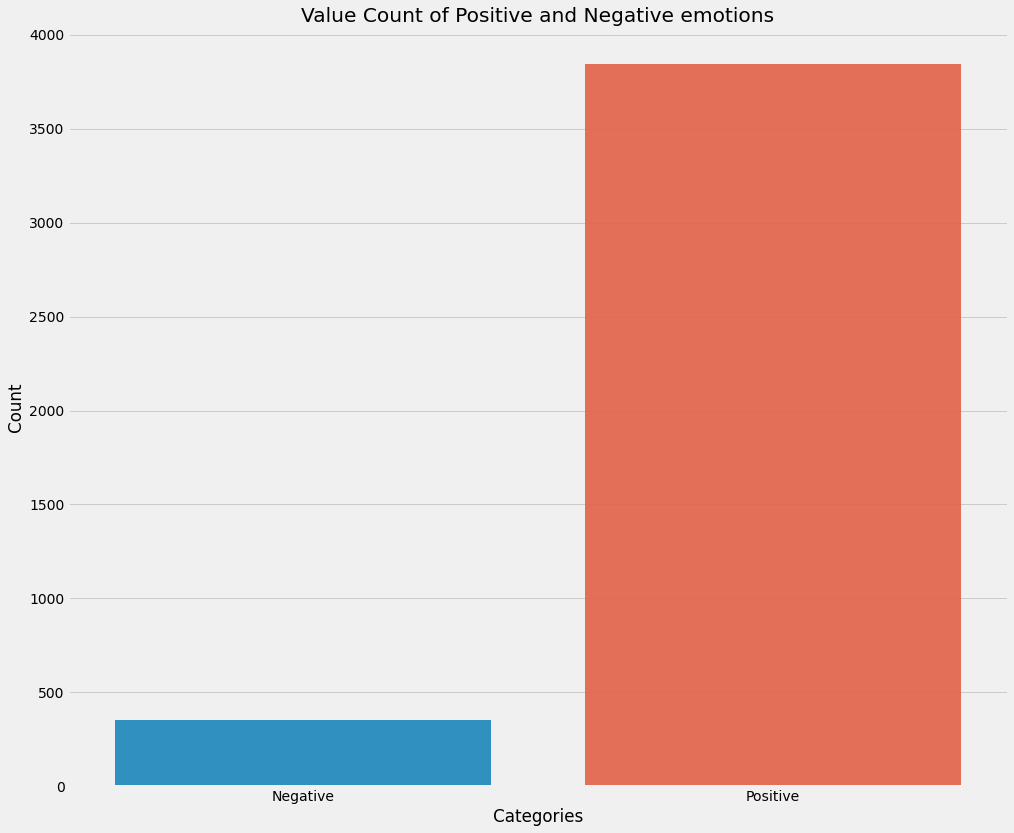

In [17]:

# Barplot
plt.figure(figsize=(15,13))
sns.barplot(['Neutral', 'Happy', 'Sad', 'Surprise'], df['class'].value_counts(), palette='Greens_d')
plt.xlabel('Emotions')
plt.ylabel('Emotion')
plt.title('Value Count of emotions')
plt.savefig('bar.jpg')

# basic changes
#Creating a new column
df['ranking'] = np.zeros((df.shape[0],1))

for i in range(df.shape[0]):
    category = df['class'][i]
    
    if category == 'Happy':
        df['ranking'][i] = 0.9
    elif category == 'Surprise':
        df['ranking'][i] = 0.7
    elif category == 'Neutral':
        df['ranking'][i] = 0.5
    else:
        df['ranking'][i] = 0.3
        
smoother = ConvolutionSmoother(window_len=30, window_type='ones')
smoother.smooth(df['ranking'])

# generate intervals
low, up = smoother.get_intervals('sigma_interval', n_sigma=3)

# plot the smoothed timeseries with intervals
plt.figure(figsize=(15,13))
plt.plot(smoother.data[0], color='orange')
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Satisfaction')
plt.title('Satisfaction rate over time')
plt.savefig('graphs/dist.jpg')


# Basic changes
df['posneg'] = np.zeros((df.shape[0],1))

for i in range(df.shape[0]):
    if df['class'][i] =='Happy' or df['class'][i] == 'Surprise' or df['class'][i] == 'Neutral':
        df['posneg'][i] = 1
    else:
        df['posneg'][i] = 0

        
y = [df['posneg'].value_counts()[0], df['posneg'].value_counts()[1]]

plt.figure(figsize=(15,13))
sns.barplot(['Negative','Positive'],y, alpha=0.9)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Value Count of Positive and Negative emotions')
plt.savefig('graphs/posneg.jpg')

[!] Converting..


100%|██████████| 644/644 [00:02<00:00, 217.75it/s]


In [23]:
if alert==1:
        pygame.mixer.init()
        pygame.mixer.music.load("alert.wav")
        pygame.mixer.music.play()
        while pygame.mixer.music.get_busy() == True:
            continue        
        s.call(['notify-send', 'Detection Done!'])
        do = False

In [8]:
x = df['class'].value_counts()

In [32]:
df['class'].

array(['Neutral', 'Neutral', 'Neutral', ..., 'Neutral', 'Neutral',
       'Neutral'], dtype=object)

In [41]:
x = df['class'].unique()
x

array(['Neutral', 'Amazed'], dtype=object)

In [44]:
len(x)

2

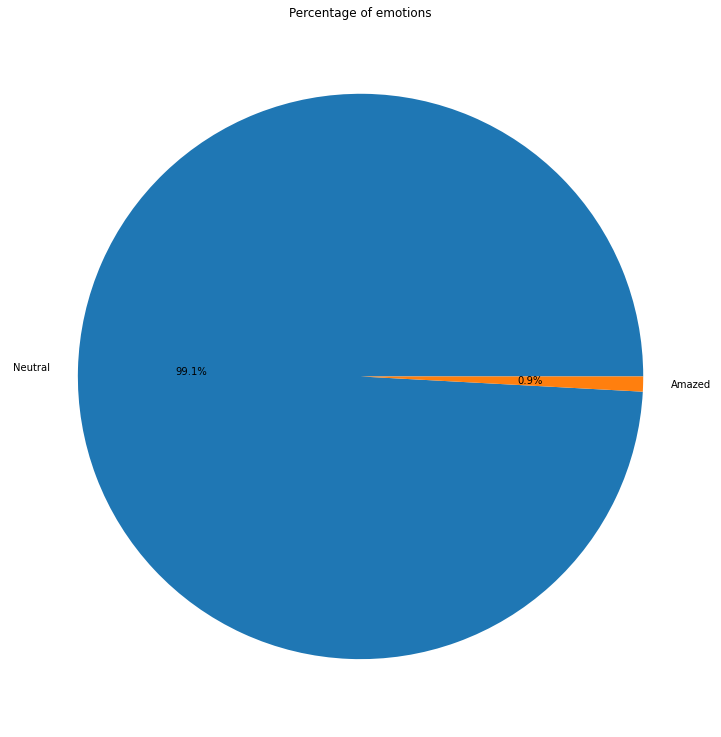

/home/adri-salman/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-1-c37e3f6aeb30>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ranking'][i] = 0.5
<ipython-input-1-c37e3f6aeb30>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ranking'][i] = 0.9
<ipython-input-1-c37e3f6aeb30>:74: SettingWithCopyWarning: 
A value is trying t

[!] Converting..


100%|██████████| 644/644 [00:02<00:00, 295.04it/s]


[!] Done!


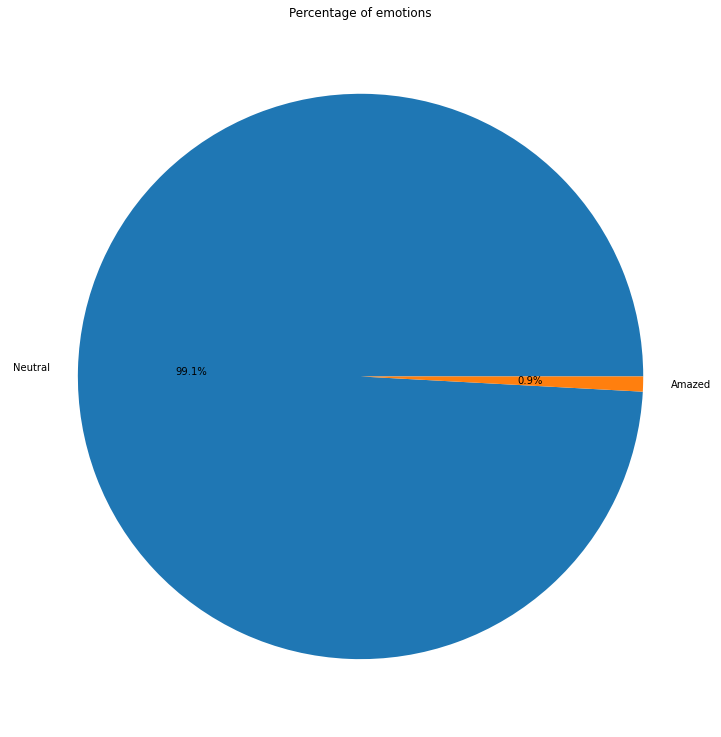

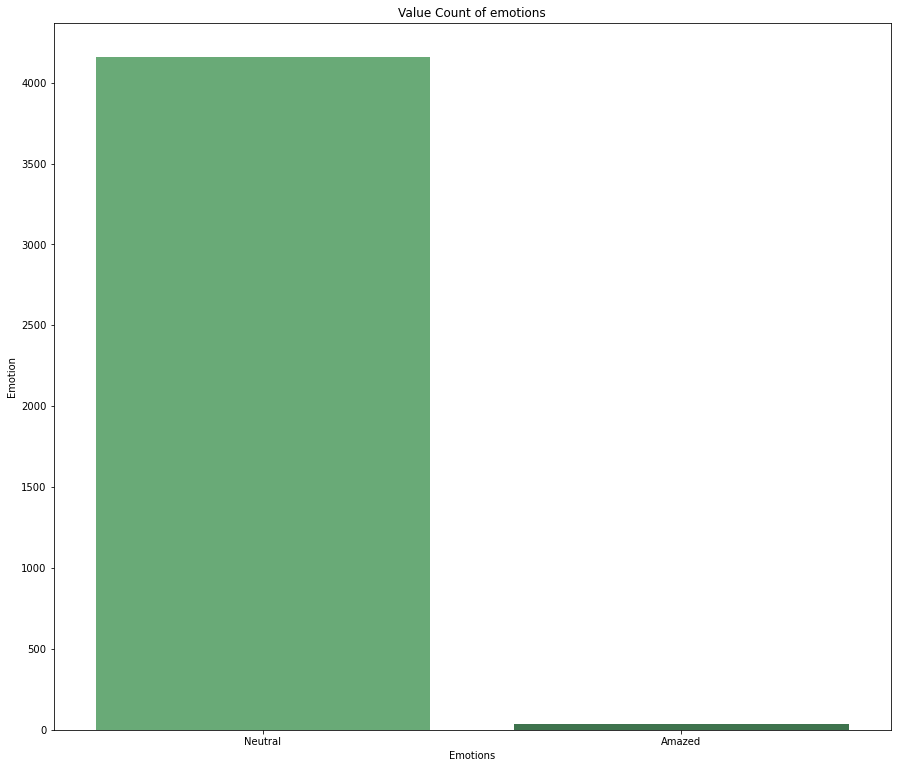

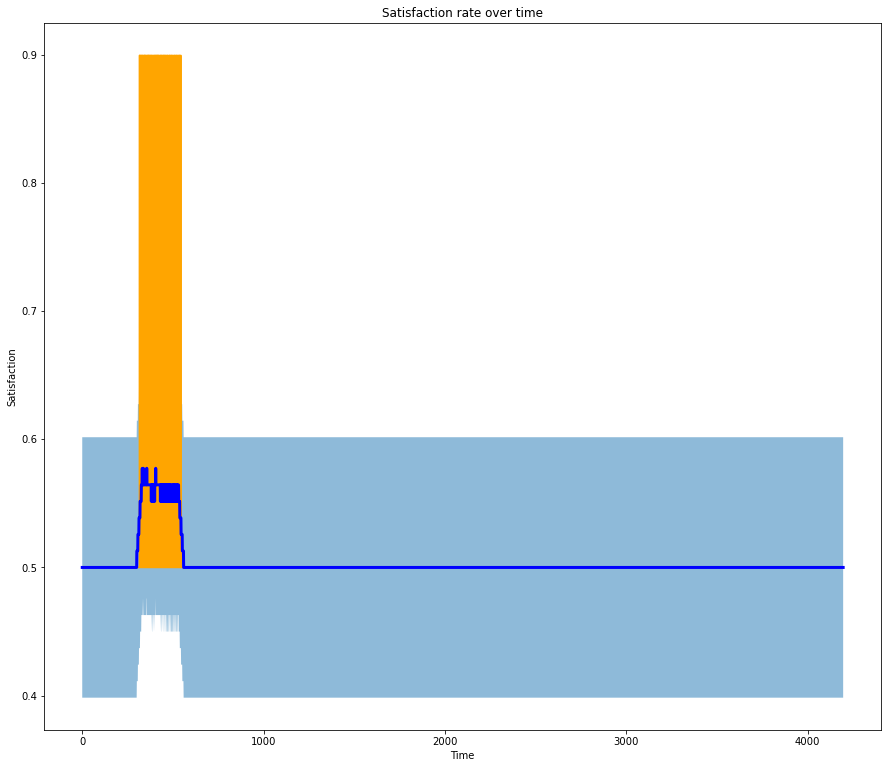